In [1]:
from sklearn.model_selection import train_test_split
from sklift import datasets
import pandas as pd
import numpy as np

import plotly.express as px

pd.set_option('display.max_columns', None)
%matplotlib inline

Dataset: Modified Uplift Model for X5 <br>
https://www.kaggle.com/competitions/x5-uplift-valid/data

<h2> Data loading <h2>

In [2]:
DATA_PATH = 'E:/Programming/RecSys/Course_work/x5-uplift-valid/'
FOLDER_DATA = DATA_PATH + 'data/'

df_clients = pd.read_csv(FOLDER_DATA + 'clients2.csv')
# df_products = pd.read_csv(FOLDER_DATA + 'products.csv')
df_train = pd.read_csv(FOLDER_DATA + 'train.csv')
df_test = pd.read_csv(FOLDER_DATA + 'test.csv')

df_train_purch = pd.read_csv(DATA_PATH + 'train_purch/train_purch.csv')
df_test_purch = pd.read_csv(DATA_PATH + 'test_purch/test_purch.csv')

<h3> Memory optimization <h3>

In [3]:
def reduce_mem_usage(df: pd.DataFrame, cols: list, type_names: list) -> pd.DataFrame:
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col, type_name in zip(cols, type_names):
        print(col)
        if type_name == 'object':
            pass
        elif type_name == 'datetime':
            df[col] = pd.to_datetime(df[col])
        else:
            df[col] = df[col].astype(type_name)
    
    end_mem = df.memory_usage().sum() / 1024**2
    red_mem = (100 * (start_mem - end_mem) / start_mem)
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    print(f'Decreased by {red_mem:.1f}%')

    return df.head(3)

In [4]:
df_clients.head(3)

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U


In [5]:
df_clients.drop(columns={'client_id.1'},
                inplace=True)

In [6]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   client_id          200039 non-null  object
 1   first_issue_date   200039 non-null  object
 2   first_redeem_date  182493 non-null  object
 3   age                200039 non-null  int64 
 4   gender             200039 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.6+ MB


In [7]:
df_cols = df_clients.columns
df_types = ['object',
            'datetime',
            'datetime',
            np.uint8,
            'category']

reduce_mem_usage(df_clients, df_cols, df_types)

Memory usage of dataframe is 7.63 MB
client_id
first_issue_date
first_redeem_date
age
gender
Memory usage after optimization is: 4.96 MB
Decreased by 35.0%


,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U


In [8]:
print(df_train_purch.info())
df_train_purch.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998952 entries, 0 to 15998951
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 1.5+ GB
None


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN


In [9]:
filtr = (df_train_purch['regular_points_spent'] < 0)
df_train_purch.loc[filtr].head(5)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
437,00020e7b18,59f74dd2aa,2019-01-23 06:48:31,1.9,0.0,-474.0,0.0,869.96,a5afe54e3f,82702fc003,1.0,105.0,230.0
438,00020e7b18,59f74dd2aa,2019-01-23 06:48:31,1.9,0.0,-474.0,0.0,869.96,a5afe54e3f,90d3519152,1.0,109.0,240.0
439,00020e7b18,59f74dd2aa,2019-01-23 06:48:31,1.9,0.0,-474.0,0.0,869.96,a5afe54e3f,365c9858f0,2.0,182.0,400.0
446,00020e7b18,1281f2b1c4,2019-02-01 08:58:12,10.5,0.0,-3.0,-10.0,1070.85,2531f694dd,3e038662c0,1.0,57.0,58.0
447,00020e7b18,1281f2b1c4,2019-02-01 08:58:12,10.5,0.0,-3.0,-10.0,1070.85,2531f694dd,4009f09b04,1.0,5.0,5.0


regular_points_spent and express_points_spent consist of negative values

In [10]:
df_train_purch['regular_points_spent'] = \
    df_train_purch['regular_points_spent'].apply(np.abs)

In [11]:
df_train_purch['express_points_spent'] = \
    df_train_purch['express_points_spent'].apply(np.abs)

In [12]:
df_cols = ['transaction_datetime',
           'regular_points_received',
           'express_points_received',
           'regular_points_spent',
           'express_points_spent',
           'purchase_sum',
           'product_quantity',
           'trn_sum_from_iss']
df_types = ['datetime',
            np.float16,
            np.float16,
            np.float16,
            np.float16,
            np.uint8,
            np.uint8,
            np.float16]

reduce_mem_usage(df_train_purch, df_cols, df_types)

Memory usage of dataframe is 1586.81 MB
transaction_datetime
regular_points_received
express_points_received
regular_points_spent
express_points_spent
purchase_sum
product_quantity
trn_sum_from_iss
Memory usage after optimization is: 915.47 MB
Decreased by 42.3%


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,9a80204f78,2,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,da89ebd374,1,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,0a95e1151d,1,24.0,NaN


In [13]:
print(df_test_purch.info())
df_test_purch.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883738 entries, 0 to 6883737
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 682.7+ MB
None


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,a375a035b9,2.0,50.0,NaN
1,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,6f9e02ee36,1.0,90.0,NaN
2,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,42e1eb8d23,1.0,20.0,NaN


In [14]:
df_test_purch['regular_points_spent'] = \
    df_test_purch['regular_points_spent'].apply(np.abs)

df_test_purch['express_points_spent'] = \
    df_test_purch['express_points_spent'].apply(np.abs)

In [15]:
df_cols = ['transaction_datetime',
           'regular_points_received',
           'express_points_received',
           'regular_points_spent',
           'express_points_spent',
           'purchase_sum',
           'product_quantity',
           'trn_sum_from_iss']
df_types = ['datetime',
            np.float16,
            np.float16,
            np.float16,
            np.float16,
            np.uint16,
            np.uint8,
            np.uint8,
            np.float16]

reduce_mem_usage(df_test_purch, df_cols, df_types)

Memory usage of dataframe is 682.74 MB
transaction_datetime
regular_points_received
express_points_received
regular_points_spent
express_points_spent
purchase_sum
product_quantity
trn_sum_from_iss
Memory usage after optimization is: 393.89 MB
Decreased by 42.3%


,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303,76d287ce03,a375a035b9,2,50,NaN
1,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303,76d287ce03,6f9e02ee36,1,90,NaN
2,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303,76d287ce03,42e1eb8d23,1,20,NaN


<h2> EDA <h2>

<h3> Clients <h3>

In [16]:
df_clients

,client_id,first_issue_date,first_redeem_date,age,gender
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U
...,...,...,...,...,...
200034,fffe0abb97,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F
200035,fffe0ed719,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U
200036,fffea1204c,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F
200037,fffeca6d22,2017-12-28 11:56:13,NaT,77,F


In [17]:
print(df_clients['age'].describe())
fig = px.box(df_clients, y='age', width=400)
fig.show()

count    200039.000000
mean         46.590095
std          16.550292
min           0.000000
25%          34.000000
50%          45.000000
75%          59.000000
max         255.000000
Name: age, dtype: float64


There are outliers in data.

In [18]:
print(df_clients['first_issue_date'].isna().sum())
print(df_clients['first_redeem_date'].isna().sum())

0
17546


In [19]:
print(df_clients['age'].isna().sum())
df_clients['age'].describe()

0


count    200039.000000
mean         46.590095
std          16.550292
min           0.000000
25%          34.000000
50%          45.000000
75%          59.000000
max         255.000000
Name: age, dtype: float64

In [20]:
print(df_clients['gender'].isna().sum())
df_clients['gender'].value_counts()

0


U    92832
F    73696
M    33511
Name: gender, dtype: int64

<h3> Purchases <h3>

In [21]:
df_purchases = pd.concat([df_train_purch, df_test_purch], 
                          axis=0,
                          ignore_index=True)
df_purchases.head(3)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,9a80204f78,2,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,da89ebd374,1,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,239,54a4a11a29,0a95e1151d,1,24.0,NaN


In [22]:
print(df_purchases['transaction_datetime'].isna().sum())
print(df_purchases['transaction_datetime'].describe())

0


C:\Users\MSI-1\AppData\Local\Temp\ipykernel_10376\3903177238.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                22882690
unique                2844962
top       2019-03-15 15:04:21
freq                      127
first     2018-11-21 21:02:33
last      2019-03-18 23:19:28
Name: transaction_datetime, dtype: object


In [23]:
print(df_purchases['store_id'].isna().sum())

0


<h2> Feature Engeneering <h2>

In [24]:
class DataPipeline:
    """Data preprocessing"""

    limit_age_min = 12
    limit_age_max = 90


    cols = ['dif_between_transactions_of_client',
            'regular_points_received',
            'express_points_received',
            'regular_points_spent',
            'express_points_spent',
            'purchase_sum']

    mean_cols = ['mean_time_between_transactions_client',
                 'mean_regular_points_received_client',
                 'mean_express_points_received_client',
                 'mean_regular_spent_client',
                 'mean_express_spent_client',
                 'mean_purchase_sum_client']

    dropped_cols = ['transaction_id',
                    'transaction_datetime',
                    'store_id',
                    'product_id',
                    'product_quantity',
                    'trn_sum_from_iss',
                    'trn_sum_from_red']

    def __init__(self):

        self.mode_client_store = None
        self.med_ages_in_stores = None
        self.min_client_transaction_datetime = None
        self.mean_target_store = None
        self.mean_value_along_cols_dict = None


    def calc_properties_for_features(self, df_clients, df_purchases, df_train):
        df_clients_purch = df_clients.merge(df_purchases, how='inner', on='client_id')
        
        # Cacl mode client in each store
        grb_by_client = df_clients_purch.groupby(by='client_id', as_index=False)
        self.mode_client_store = grb_by_client['store_id'].agg(lambda x: self._calc_mode_func_series(x))
        self.mode_client_store.rename(columns={'store_id': 'mode_client_store'},
                                      inplace=True)

        # Cacl median client ages in each store
        grb_by_store = df_clients_purch.groupby(by='store_id', as_index=False)
        self.med_ages_in_stores = grb_by_store['age'].agg(pd.Series.median)
        self.med_ages_in_stores.rename(columns={'age': 'median_client_ages_in_store'},
                                  inplace=True)

        filtr_min_age = self.med_ages_in_stores['median_client_ages_in_store'] < self.limit_age_min
        filtr_max_age = self.med_ages_in_stores['median_client_ages_in_store'] > self.limit_age_max

        self.med_ages_in_stores.loc[filtr_min_age | filtr_max_age,
                                    'median_client_ages_in_store'] = \
                                    self.med_ages_in_stores['median_client_ages_in_store'].median()

        # Compute minimal datatime of transaction for each client 
        self.min_client_transaction_datetime = \
                        grb_by_client['transaction_datetime'].agg(pd.Series.min)
        self.min_client_transaction_datetime.rename(columns={'transaction_datetime': 
                                                             'min_transaction_datetime'},
                                            inplace=True)
        
        #Compute mean target point 
        df_clients_transactions = df_clients_purch[['client_id',
                                            'transaction_id',
                                            'transaction_datetime',
                                            'regular_points_received',
                                            'express_points_received',
                                            'regular_points_spent',
                                            'express_points_spent',
                                            'purchase_sum',
                                            'store_id']]
    
        df_clients_transactions = \
            df_clients_transactions.drop_duplicates(subset=['transaction_id'])


        df_train_ext = df_train.merge(df_clients_transactions,
                                      how='inner',
                                      on='client_id')

        grb_by_store = df_train_ext.groupby(by='store_id', as_index=False)
        self.mean_target_store = grb_by_store['target'].mean()
        self.mean_target_store.rename(columns={'store_id':
                                               'mode_client_store',
                                               'target': 
                                               'mean_target_points_store'},
                                      inplace=True)

        #Compute mean time in hours between transactions for each clients
        #Compute mean recieved and spent points between transactions for each clients
        #Compute mean purchase_sum between transactions for each clients

        df_clients_transactions['transaction_datetime'] = \
            (df_clients_transactions['transaction_datetime'] \
            - pd.to_datetime('2015-01-01 00:00:00')).astype('timedelta64[h]')

        grb_by_client = df_clients_transactions.groupby(by=['client_id'], as_index=False)
        diff_client_transaction_datetime = grb_by_client['transaction_datetime'].diff()
        diff_client_transaction_datetime.fillna(0, inplace=True)
        diff_client_transaction_datetime.rename(columns={'transaction_datetime': 
                                                         'dif_between_transactions_of_client'},
                                                inplace=True)
        df_clients_transactions = \
            df_clients_transactions.join(diff_client_transaction_datetime,
                                         how='left')

        grb_by_client = df_clients_transactions.groupby(by=['client_id'], as_index=False)

        self.mean_value_along_cols_dict = {}

        for col, mean_col in zip(self.cols, self.mean_cols):

            mean_values_col_client = grb_by_client[col].mean()
            mean_values_col_client.rename(columns={col: mean_col},
                                          inplace=True)

            self.mean_value_along_cols_dict[mean_col] = mean_values_col_client


    def transform_features(self, df_clients, df_purchases, df_out):
        df_clients_purch = df_clients.merge(df_purchases, how='inner', on='client_id')

        # Transform min and max ages of clients
        df_clients_purch = df_clients_purch.merge(self.mode_client_store, 
                                                  how='inner', 
                                                  on='client_id')
        
        df_clients_purch = df_clients_purch.merge(self.med_ages_in_stores, 
                                                  how='inner', 
                                                  on='store_id')

        filtr_min_age = df_clients_purch['age'] < self.limit_age_min
        filtr_max_age = df_clients_purch['age'] > self.limit_age_max

        df_clients_purch.loc[filtr_min_age | filtr_max_age,
                            'age'] = \
                             df_clients_purch.loc[filtr_min_age | filtr_max_age,
                                                'median_client_ages_in_store']

        # Add mean target points to mode store of client
        df_clients_purch = df_clients_purch.merge(self.mean_target_store,
                                                  how='inner',
                                                  on='mode_client_store')

        #Compute difference between first_redem and first_issue data

        df_clients_purch = \
             df_clients_purch.merge(self.min_client_transaction_datetime, 
                                    how='inner', 
                                    on='client_id')

        df_clients_purch['first_redeem_date'].fillna(df_clients_purch['min_transaction_datetime'],
                                                     inplace=True)
        df_clients_purch['dif_first_issue_and_redeem_date_in_h'] = \
            (df_clients_purch['first_redeem_date'] - \
             df_clients_purch['first_issue_date']).astype('timedelta64[h]')

        filtr = df_clients_purch['dif_first_issue_and_redeem_date_in_h'] < 0
        df_clients_purch.loc[filtr,
                    'dif_first_issue_and_redeem_date_in_h'] = 0
        df_clients_purch.drop(columns={'median_client_ages_in_store',
                                       'first_issue_date',
                                       'first_redeem_date',
                                       'min_transaction_datetime'},
                              inplace=True)
        


        #Merge columns with mean values
        for col, mean_col in zip(self.cols, self.mean_cols):

            df_clients_purch = df_clients_purch.merge(self.mean_value_along_cols_dict[mean_col], 
                                                      how='inner', 
                                                      on='client_id')
            
            if col in df_clients_purch.columns:
                df_clients_purch.drop(columns=col,
                                      inplace=True)

        df_clients_purch.drop(columns=self.dropped_cols,
                              inplace=True)

        #Merge columns with mean values
        df_out = df_out.merge(df_clients_purch,
                              how='inner',
                              on='client_id')
        df_out = df_out.drop_duplicates(subset=['client_id'],
                                        ignore_index = True)

        return df_out

    def _calc_mode_func_series(self, x):
        x = pd.Series.mode(x)[0]
        return x


In [25]:
data_preprocessing = DataPipeline()

In [26]:
data_preprocessing.calc_properties_for_features(df_clients, df_purchases, df_train)

In [27]:
df_train_transformed = \
    data_preprocessing.transform_features(df_clients, df_purchases, df_train)

In [28]:
df_test_transformed = \
    data_preprocessing.transform_features(df_clients, df_purchases, df_test)

In [29]:
df_train_transformed.head(3)

,client_id,treatment_flg,target,age,gender,mode_client_store,mean_target_points_store,dif_first_issue_and_redeem_date_in_h,mean_time_between_transactions_client,mean_regular_points_received_client,mean_express_points_received_client,mean_regular_spent_client,mean_express_spent_client,mean_purchase_sum_client
0,ad6561e2d8,1,1,50.0,F,658cf09cd4,0.904478,4105.0,67.925000,2.431641,0.0,1.599609,0.0,122.575000
1,7c1ccbf93f,1,1,24.0,F,5e263ad173,0.605000,2498.0,171.000000,4.699219,0.0,0.000000,0.0,169.500000
2,b58fadcab6,1,1,36.0,U,251d468760,0.813725,7607.0,82.787879,2.773438,0.0,9.367188,0.0,134.333333


<h2> Learning <h2>

In [30]:
# Features for learning
features_learn = ['age',
                  'mode_client_store',
                  'gender', 
                  'mean_target_points_store',
                  'dif_first_issue_and_redeem_date_in_h',
                  'mean_time_between_transactions_client',
                  'mean_regular_points_received_client',
                  'mean_express_points_received_client', 
                  'mean_regular_spent_client',
                  'mean_express_spent_client', 
                  'mean_purchase_sum_client']

In [31]:
indices_learn, indices_valid = train_test_split(df_train_transformed.index, 
                                                test_size=0.3, 
                                                random_state=57)

In [32]:
X_train = df_train_transformed.loc[indices_learn, features_learn]
y_train = df_train_transformed.loc[indices_learn, 'target']
treat_train = df_train_transformed.loc[indices_learn, 'treatment_flg']


X_val = df_train_transformed.loc[indices_valid, features_learn]
y_val = df_train_transformed.loc[indices_valid, 'target']
treat_val = df_train_transformed.loc[indices_valid, 'treatment_flg']

X_test = df_test_transformed[features_learn]

In [33]:
models_results = {
    'approach': [],
    'uplift@30%': []
}

<h3> Single model approaches <h3>

In [34]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [35]:
cat_features = ['gender', 'mode_client_store']

sm = SoloModel(CatBoostClassifier(iterations=200,
                                  learning_rate=0.05, 
                                  thread_count=20,
                                  random_state=57,
                                  silent=True))

sm_score: 0.06510975985479128


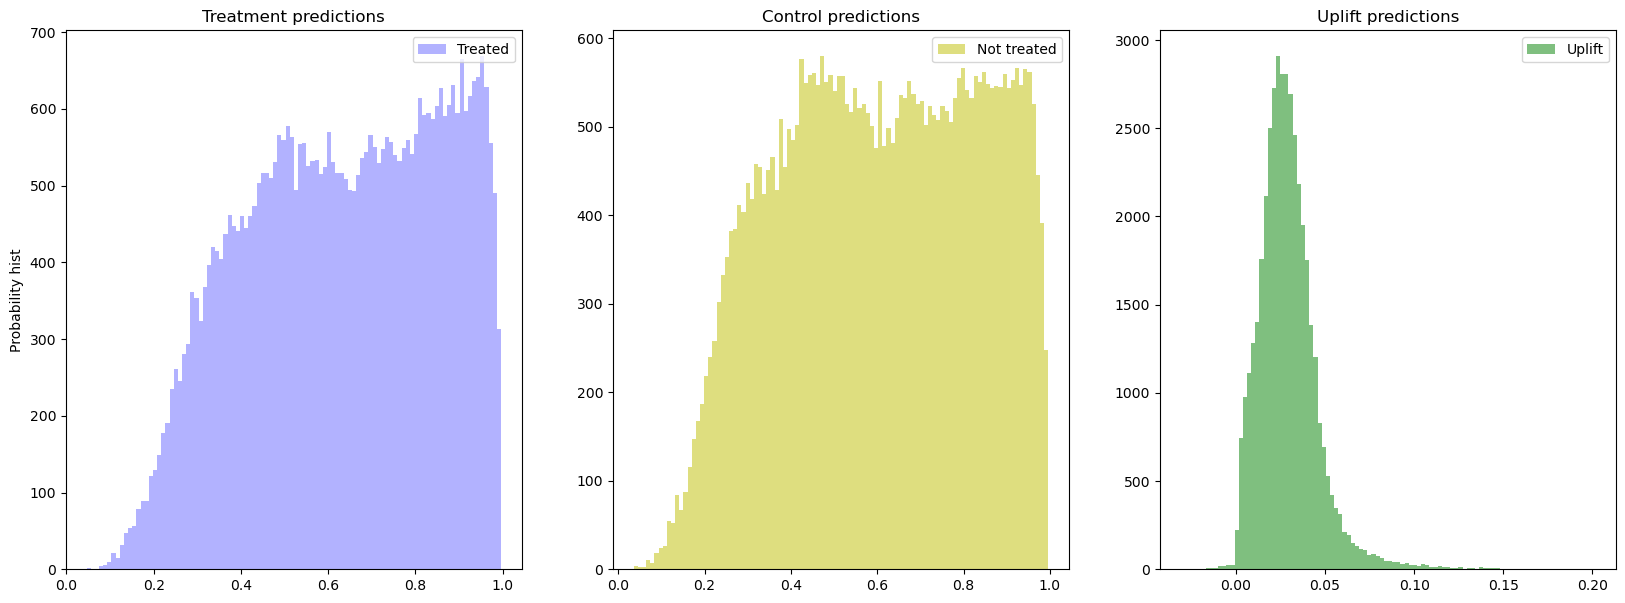

In [36]:
sm = sm.fit(X_train, y_train, treat_train, 
            estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, 
                       uplift=uplift_sm, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=0.3)

print(f'sm_score: {sm_score}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [37]:
# You can also access the trained model with the same ease.
# For example, to build the importance of features:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,mean_time_between_transactions_client,45.797963
1,mean_target_points_store,33.920095
2,mode_client_store,5.011473
3,mean_regular_spent_client,4.106502
4,mean_purchase_sum_client,3.206393
5,dif_first_issue_and_redeem_date_in_h,2.240017
6,age,2.163109
7,treatment,1.282462
8,mean_express_spent_client,0.936228
9,mean_regular_points_received_client,0.695201


<h3> Class Transformation <h3>

In [38]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=200,
                                            learning_rate=0.05, 
                                            thread_count=20,
                                            random_state=57,
                                            silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, 
                       uplift=uplift_ct, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=0.3)

print(f'ct_score: {ct_score}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

# You can also access the trained model with the same ease.
# For example, to build the importance of features:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)
ct_fi

ct_score: 0.05849508210000465


,feature_name,feature_score
0,mode_client_store,14.586118
1,age,11.353857
2,mean_express_spent_client,10.873726
3,gender,9.880895
4,dif_first_issue_and_redeem_date_in_h,9.514921
5,mean_regular_points_received_client,9.012537
6,mean_time_between_transactions_client,8.861004
7,mean_purchase_sum_client,7.990460
8,mean_target_points_store,7.444828
9,mean_regular_spent_client,6.042918


<h3> Two independent model <h3>

tm_score: 0.06013151072914846


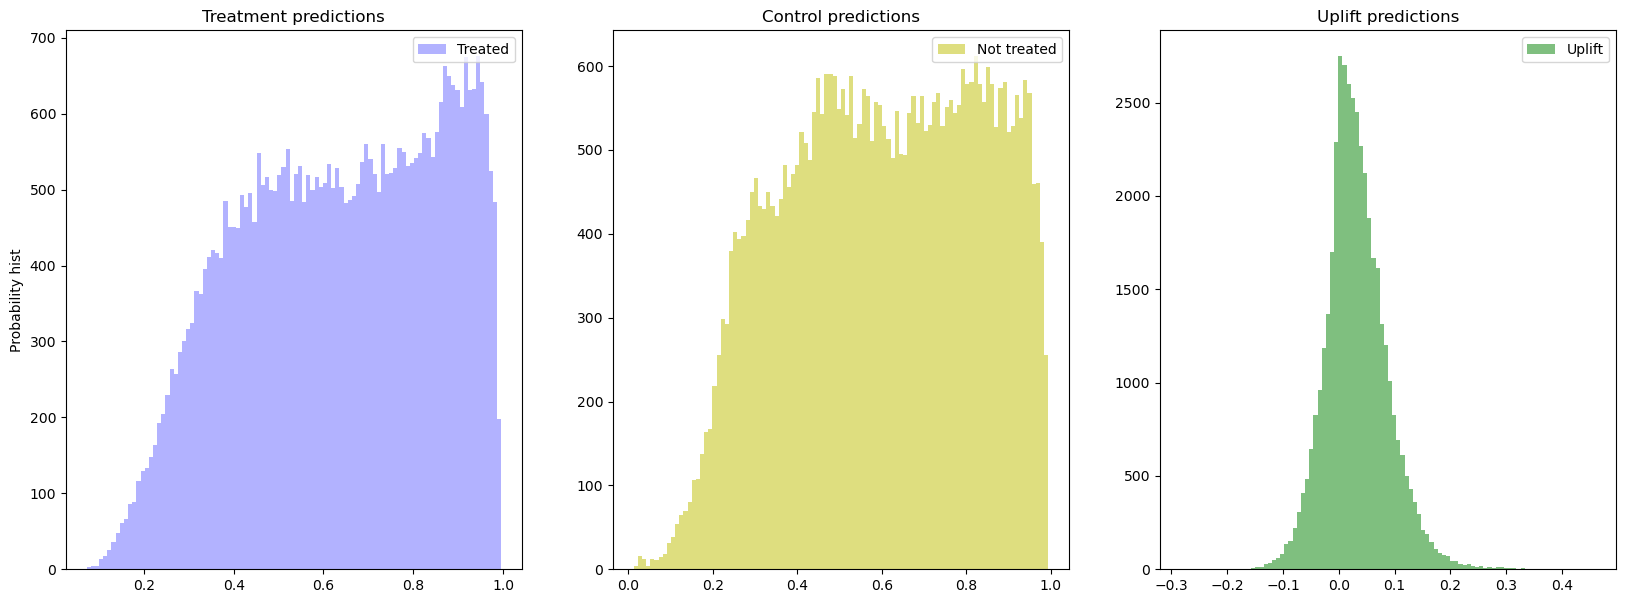

In [39]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=200,
                                       learning_rate=0.05, 
                                       thread_count=20,
                                       random_state=57,
                                       silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=200,
                                      learning_rate=0.05, 
                                      thread_count=20,
                                      random_state=57,
                                      silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

print(f'tm_score: {tm_score}')

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

<h3> Two dependent models <h3>

In [40]:
from sklift.models import TwoModels

tm_ctrl_score: 0.041981232730224916


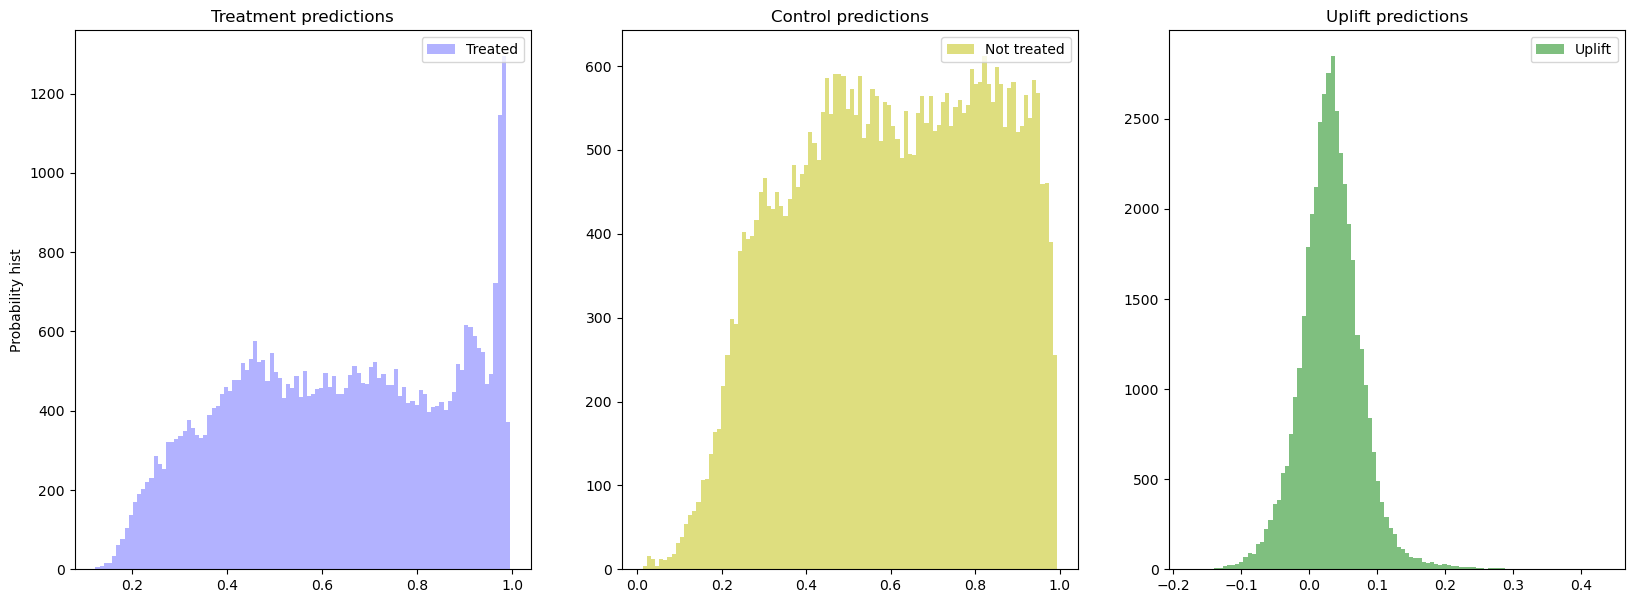

In [41]:
tm_ctrl = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=200,
                                  learning_rate=0.05, 
                                  thread_count=20,
                                  random_state=57,
                                  silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=200,
                                  learning_rate=0.05, 
                                  thread_count=20,
                                  random_state=57,
                                  silent=True), 
    method='ddr_control'
)
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm_ctrl = tm_ctrl.predict(X_val)

tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treat_val, strategy='by_group', k=0.3)

print(f'tm_ctrl_score: {tm_ctrl_score}')

models_results['approach'].append('TwoModels_ddr_control')
models_results['uplift@30%'].append(tm_ctrl_score)

plot_uplift_preds(trmnt_preds=tm_ctrl.trmnt_preds_, ctrl_preds=tm_ctrl.ctrl_preds_);

<h3> Model Comparizon <h3>

In [42]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%
0,SoloModel,0.065110
2,TwoModels,0.060132
1,ClassTransformation,0.058495
3,TwoModels_ddr_control,0.041981


SoloModel shows the best permofmance in comparison of other models.

To learn the SoloModel on all train dataset

In [43]:
X_train = df_train_transformed[features_learn]
y_train = df_train_transformed['target']
treat_train = df_train_transformed['treatment_flg']

sm_score: 0.07722537669846524


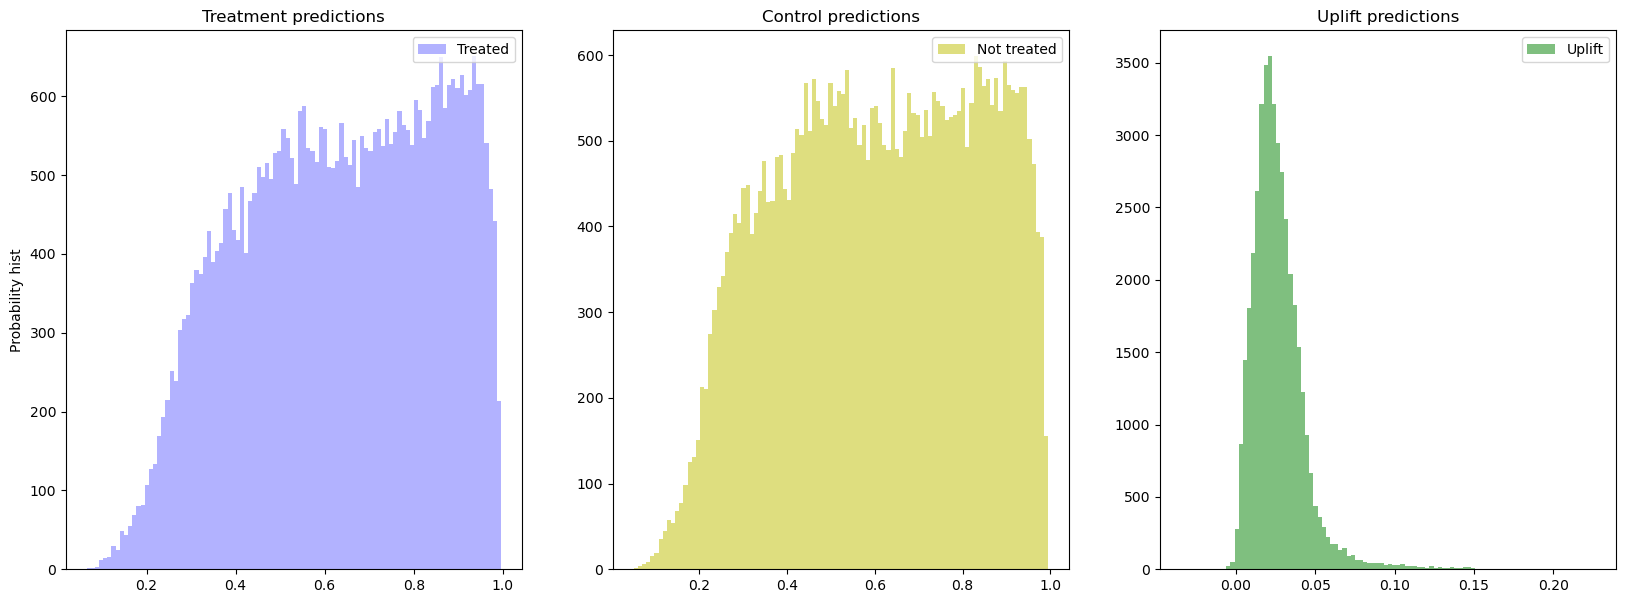

In [48]:
sm = sm.fit(X_train, y_train, treat_train, 
            estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, 
                       uplift=uplift_sm, 
                       treatment=treat_val, 
                       strategy='by_group', 
                       k=0.3)

print(f'sm_score: {sm_score}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

<h3> Save model <h3>

In [49]:
import pickle

In [50]:
filename = 'solo_model.sav'
pickle.dump(sm, open(filename, 'wb'))

Save fields of Data Pipeline

In [63]:
dict_for_saving = vars(data_preprocessing)

In [65]:
with open('saved_datapreprocessing_fields.pkl', 'wb') as f:
    pickle.dump(dict_for_saving, f)